In [10]:
# !pip install pytesseract
# https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w64-setup-v5.0.0-alpha.20190623.exe

In [1]:
import numpy as np
from PIL import ImageGrab
import cv2
# from pytesseract import image_to_string
import matplotlib.pyplot as plt
import os
from time import sleep
from sklearn.cluster import DBSCAN

In [7]:
import pytesseract

In [2]:
image_files = ["data\\" + fname for fname in os.listdir('data') if fname[-4:] == '.jpg']
image_files

['data\\20190704011308_1.jpg',
 'data\\20190704011309_1.jpg',
 'data\\20190704011313_1.jpg',
 'data\\20190704011347_1.jpg',
 'data\\20190704011353_1.jpg',
 'data\\20190704011428_1.jpg',
 'data\\20190704011500_1.jpg',
 'data\\20190704011503_1.jpg',
 'data\\20190704194652_2.jpg',
 'data\\20190705003123_1.jpg',
 'data\\20190705003126_1.jpg',
 'data\\20190705003203_1.jpg',
 'data\\20190705003212_1.jpg',
 'data\\20190705003215_1.jpg',
 'data\\20190705003217_1.jpg',
 'data\\20190705003220_1.jpg',
 'data\\20190705003223_1.jpg',
 'data\\20190705003225_1.jpg',
 'data\\20190705003227_1.jpg',
 'data\\20190705003232_1.jpg',
 'data\\20190705003236_1.jpg',
 'data\\20190705003238_1.jpg',
 'data\\20190705003242_1.jpg',
 'data\\20190705003245_1.jpg',
 'data\\20190705003247_1.jpg',
 'data\\20190705003250_1.jpg',
 'data\\20190705003253_1.jpg',
 'data\\20190705003258_1.jpg',
 'data\\image_104.jpg',
 'data\\image_108.jpg',
 'data\\image_109.jpg',
 'data\\image_116.jpg',
 'data\\image_118.jpg',
 'data\\imag

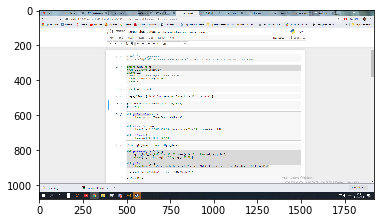

In [57]:
plt.imshow(getScreenShot((0,0,1920,1080)))
plt.show()

In [3]:
def getScreenShot(bbox):
    return np.array(ImageGrab.grab(bbox))


def getSpeedShot(img):
    return (img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)

def getMapShot(img):
    return img[795:1051,1627:1883]

In [8]:
import pickle
from digit_detector import digit_detector

def getSpeedDigits(full_img):
    img = (full_img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)
    return [img[:,:16],img[:,17:33],img[:,35:51]]

def getSpeed(full_img):
    return int("".join(digit_detector.predict(np.array([d.flatten() for d in getSpeedDigits(full_img)]))))

img = plt.imread("data\\" +  os.listdir('data')[0])

getSpeed(img)  



ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [31]:
import pickle
with open("digit_detector.pkl", 'wb') as file:
    pickle.dump(clf, file)

In [52]:
import win32gui

def drawText(tx,ty,text):
    hdc=win32gui.GetDC(0)
    hwnd=win32gui.WindowFromPoint((0,0))
    win32gui.DrawText(hdc,text, -1, (tx,ty,tx+200,ty+200),0)
    win32gui.ReleaseDC(hwnd,hdc)

In [56]:
drawText(200,200,"HELLO")

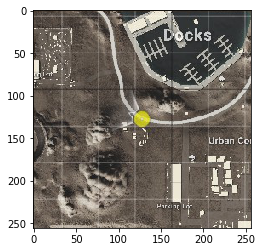

In [77]:
img = plt.imread(image_files[0])
mp = img[795:1051,1627:1883]
plt.imshow(mp)
plt.show()

In [211]:



def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask
    cv2.fillPoly(mask, vertices, 255)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked

def erase_region(img,vertices):
    #blank mask:
    mask = np.zeros_like(img)
    mask = mask + 255
    # fill the mask
    cv2.fillPoly(mask, vertices, 0)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked
    

def draw_lines(img,lines,color = [255,255,255],size=3):
    if lines is not None:
        for coords in lines:
            coords = coords.astype(np.int32)
            cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), color, size)

def process_img(image,debug=False,showHough = False):

    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()
        sleep(2)
        
    image = cv2.bilateralFilter(image,5,75,75)
    
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()
        sleep(0.5)
 
    processed_img =  cv2.Canny(image, threshold1 = 100, threshold2=100)
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    h,w = image.shape[:2]
    
    vertices = np.array([[0,780],[0,600],[480,350],[1440,350],[w,600],[w,780]], np.int32)
    
    car = np.array([[500,h],[850,450],[1050,450],[1500,h]],np.int32)
    
#     gui = np.array([[0,900],[300,900],[300,1080],[0,1080]],np.int32)
    
    processed_img = roi(processed_img, [vertices])
    processed_img = erase_region(processed_img, [car])
#     processed_img = erase_region(processed_img,[gui] )

    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    lines = cv2.HoughLinesP(processed_img,rho = 1.5,theta = 1*np.pi/180,threshold = 100,minLineLength = 100,maxLineGap = 100)
    if lines is not None:
        lines = lines[:,0,:]
        line_angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])*180/3.14
        lines = lines[(line_angles  > 105) | (line_angles  < 80) ]
     
    if debug or showHough:
        plt.figure(figsize=(20,20))
        draw_lines(processed_img,lines)
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    return lines

def getBorderLines(img,debug=False,*args,**kwargs):
    lines = process_img(img,debug,*args,**kwargs)
    clst = DBSCAN(eps=0.1,min_samples=2)
    angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])
    preds = clst.fit_predict(angles[:,None])
    print(preds)
    line1,line2 = None,None
    if (preds==0).any():
        line1 = lines[preds==0].mean(axis=0)
    if (preds==1).any():
        line2 = lines[preds==1].mean(axis=0)
   
    return line1,line2

def extend_lines(lines,scale):
    extended = []
    for line in lines:
        if line is not None:
            p1 = line[:2]
            p2 = line[2:]
            x1,y1 = (p1 + p2)*0.5 - (p2 - p1) * scale*0.5
            x2,y2 = (p1 + p2)*0.5 + (p2 - p1) * scale*0.5
            extended.append(np.array([x1,y1,x2,y2]))
    return extended

def limit_lines(lines, limit):
    results = []
    for line in lines:
        if line is not None:
            y_max_index = np.argmax(line[1::2])
            if y_max_index == 0:
                p1 = line[[0,1]]
                p2 = line[[2,3]]
            else:
                p2 = line[[0,1]]
                p1 = line[[2,3]]

            l = (p2 - p1)
            k = l[1]/l[0]
            x= p1[0] + -(p1[1] - limit)/k

            results.append(np.array([*p1,x,limit]))
    return results
        

data\image_330.jpg


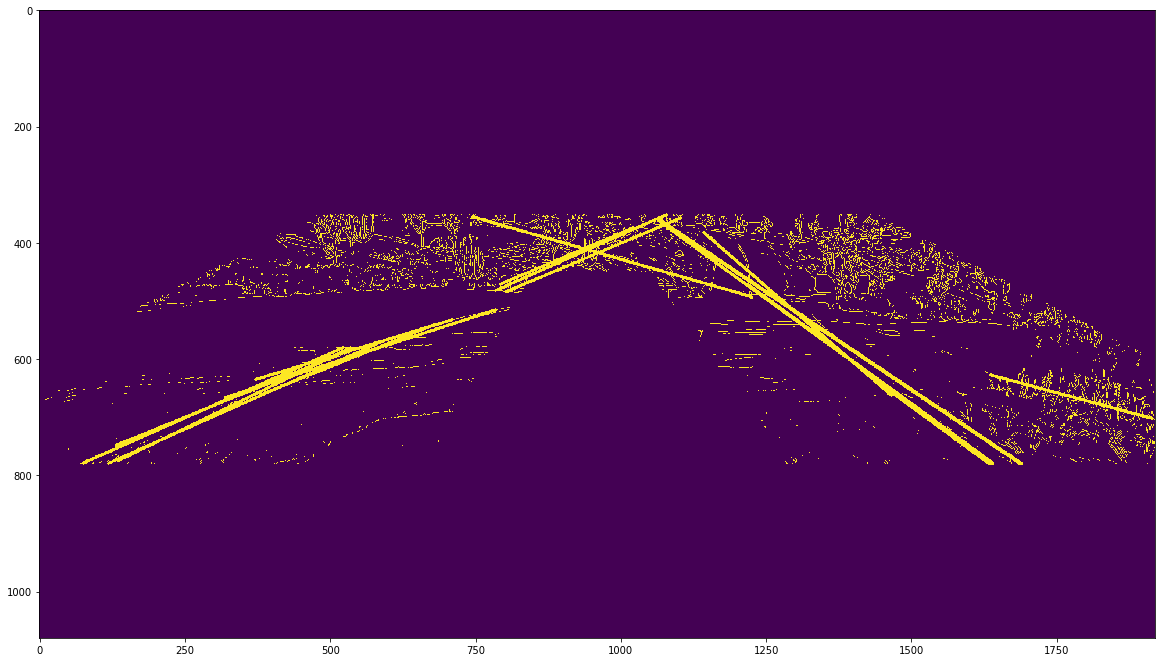

[0 0 1 1 0 1 1 1 0 2 1 0 1 1 1 2 0 1]


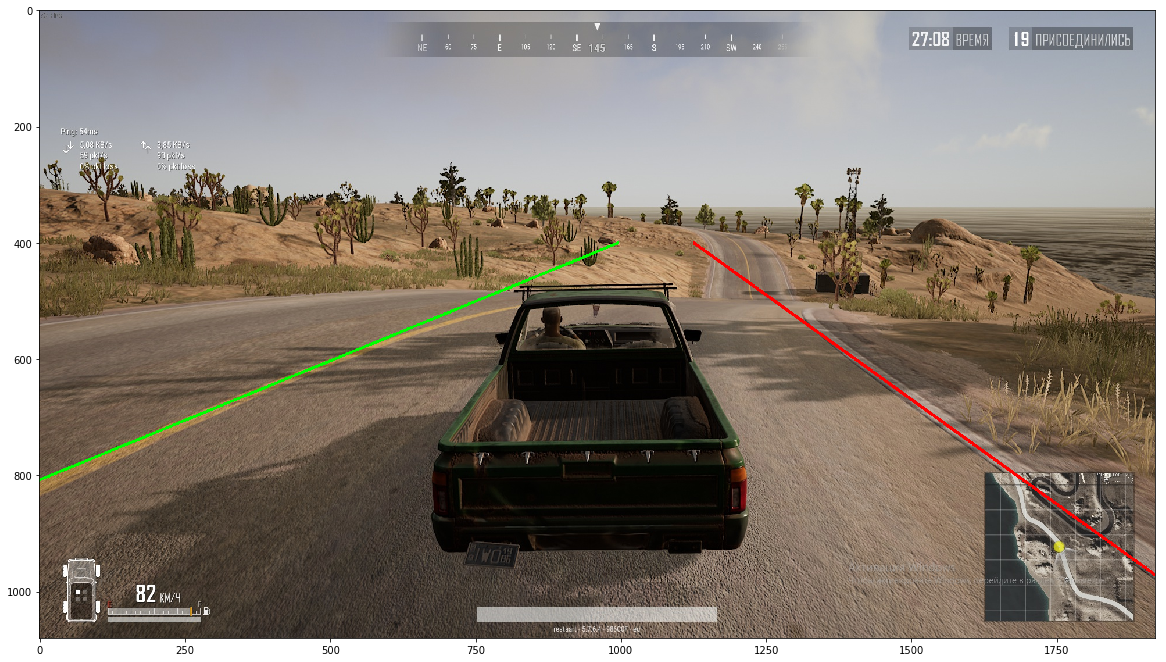

In [218]:
fimg = image_files[50]
orig = plt.imread(fimg)
print(fimg)

img = orig.copy()
lines = getBorderLines(img,debug=False,showHough=True)

lines = extend_lines(lines,5)
lines = limit_lines(lines,400)

if(len(lines) > 0 and lines[0] is not None):
    draw_lines(img,[lines[0]],[255,0,0])
if(len(lines) > 1 and lines[1] is not None):
    draw_lines(img,[lines[1]],[0,255,0])

plt.figure(figsize=(20,20))
plt.imshow(img)

plt.show()

In [214]:
plt.show()

In [210]:
f,a = plt.subplots(ncols=3,nrows=10,figsize=(20,60))

for ax,fimg in zip(a.flatten(),image_files[40:40+len(a.flatten())]):
    orig = plt.imread(fimg)

    img = orig.copy()
    lines = getBorderLines(img,debug=False,showHough=False)

    lines = extend_lines(lines,5)
    lines = limit_lines(lines,400)

    if(len(lines) > 0 and lines[0] is not None):
        draw_lines(img,[lines[0]],[255,0,0],size=20)
    if(len(lines) > 1 and lines[1] is not None):
        draw_lines(img,[lines[1]],[0,255,0],size=20)
    ax.set_title(fimg.split('\\')[1] + f" ix={image_files.index(fimg)}")
    ax.imshow(img)
    
# plt.show()
f.tight_layout()
f.savefig('file.jpg')


In [142]:
lines = process_img(img)
clst = DBSCAN(eps=0.1,min_samples=2)
angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])
# preds = clst.fit_predict(np.hstack([(lines - lines.mean(axis=0))/lines.std(axis=0)]))
preds = clst.fit_predict(angles[:,None])
preds

array([0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2], dtype=int64)

In [152]:
angles[preds==2]

array([1.08249342, 1.08201936, 1.11771171, 1.11649424, 1.11575683,
       1.08012827])

In [30]:
lines

[array([-1744.        ,  1143.5       ,   872.53422667,   400.        ])]

In [570]:
%%timeit
getBorderLines(orig)

69.7 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


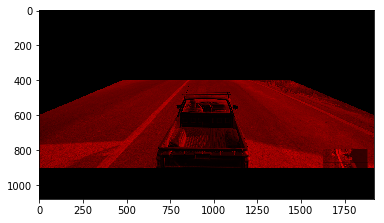

In [14]:
orig = plt.imread(image_files[10])
vertices = np.array([[0,900],[0,600],[480,400],[1440,400],[1920,600],[1920,900]], np.int32)
processed_img = roi(orig, [vertices])
plt.imshow(processed_img)
plt.show()

7.5

In [453]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
clst = DBSCAN(eps=0.4)
# clst = KMeans(n_clusters=2)
angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])
X = np.hstack([lines,angles[:,None]])
preds = clst.fit_predict(angles[:,None])
preds

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int64)

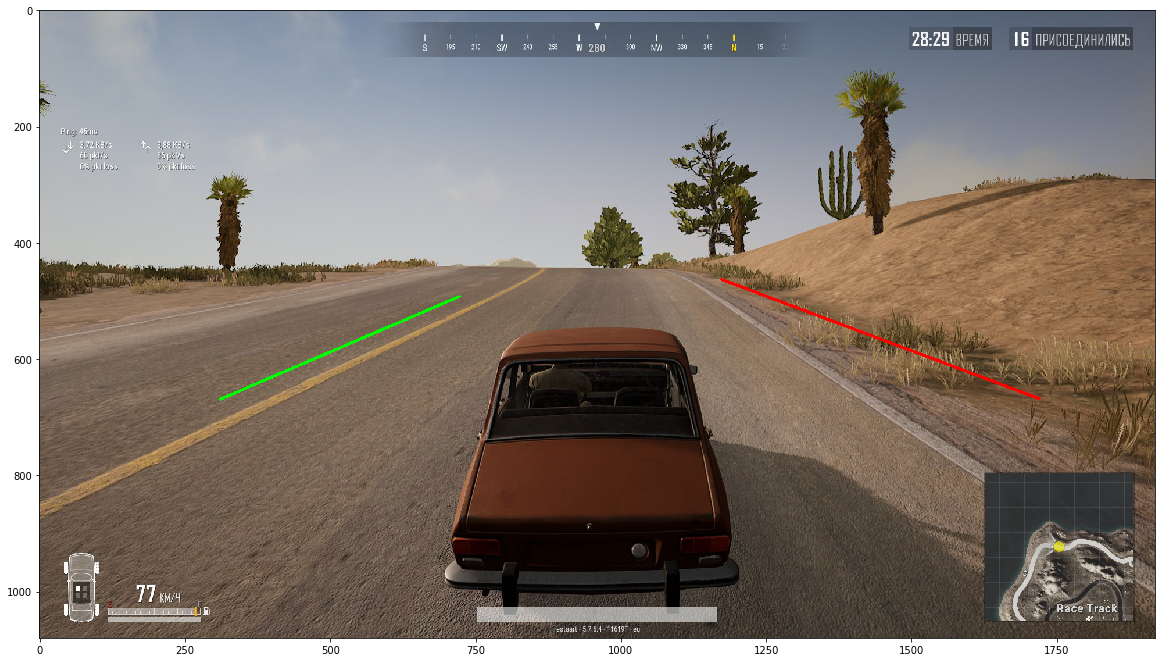

In [454]:
im = orig.copy()
plt.figure(figsize=(20,20))
# draw_lines(im,lines[preds==1],[255,0,0])
# draw_lines(im,lines[preds==0],[0,255,0])
draw_lines(im,[lines[preds==1].mean(axis=0)],[255,0,0])
draw_lines(im,[lines[preds==0].mean(axis=0)],[0,255,0])
plt.imshow(im)
plt.show()


In [339]:
lines[preds==0].mean(axis=0)

array([1269.93333333,  416.46666667, 1765.4       ,  607.06666667])

In [205]:
def getScreenShot(bbox):
    return np.array(ImageGrab.grab(bbox))

def getSpeedDigits(full_img):
    img = (full_img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)
    return [img[:,:16],img[:,17:33],img[:,35:51]]

def getSpeed(full_img):    
    return ("".join(digit_detector.predict(np.array([d.flatten() for d in getSpeedDigits(full_img)]))))


def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask
    cv2.fillPoly(mask, vertices, 255)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked

def erase_region(img,vertices):
    #blank mask:
    mask = np.zeros_like(img)
    mask = mask + 255
    # fill the mask
    cv2.fillPoly(mask, vertices, 0)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked
    

def draw_lines(img,lines,color = [255,255,255],size=3):
    if lines is not None:
        for coords in lines:
            if(coords is not None):
                coords = coords.astype(np.int32)
                cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), color, size)

def process_img(image,debug=False):

    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()
        sleep(2)
        
    image = cv2.bilateralFilter(image,5,75,75)
    
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()
        sleep(0.5)
 
    processed_img =  cv2.Canny(image, threshold1 = 100, threshold2=100)
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    h,w = image.shape[:2]
    
    vertices = np.array([[0,780],[0,600],[480,350],[1440,350],[w,600],[w,780]], np.int32)
    
    car = np.array([[500,h],[850,450],[1050,450],[1500,h]],np.int32)
    
#     gui = np.array([[0,900],[300,900],[300,1080],[0,1080]],np.int32)
    
    processed_img = roi(processed_img, [vertices])
    processed_img = erase_region(processed_img, [car])
#     processed_img = erase_region(processed_img,[gui] )

    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    lines = cv2.HoughLinesP(processed_img,rho = 1,theta = 1*np.pi/180,threshold = 100,minLineLength = 200,maxLineGap = 100)
    if lines is not None:
        lines = lines[:,0,:]
        line_angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])*180/3.14
        lines = lines[(line_angles  > 100) | (line_angles  < 80) ]
     
    if debug:
        plt.figure(figsize=(20,20))
        draw_lines(processed_img,lines)
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    return lines

def getBorderLines(img,debug=False):
    lines = process_img(img,debug)
    if(len(lines)>0):
        clst = DBSCAN(eps=0.4)
        angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])
        preds = clst.fit_predict(angles[:,None])
        line1,line2 = None,None
        if (preds==0).any():
            line1 = lines[preds==0].mean(axis=0)
        if (preds==1).any():
            line2 = lines[preds==1].mean(axis=0)

        return line1,line2
    else:
        return None,None

def extend_lines(lines,scale):
    extended = []
    for line in lines:
        if line is not None:
            p1 = line[:2]
            p2 = line[2:]
            x1,y1 = (p1 + p2)*0.5 - (p2 - p1) * scale*0.5
            x2,y2 = (p1 + p2)*0.5 + (p2 - p1) * scale*0.5
            extended.append(np.array([x1,y1,x2,y2]))
    return extended

def limit_lines(lines, limit):
    results = []
    for line in lines:
        if line is not None:
            y_max_index = np.argmax(line[1::2])
            if y_max_index == 0:
                p1 = line[[0,1]]
                p2 = line[[2,3]]
            else:
                p2 = line[[0,1]]
                p1 = line[[2,3]]

            l = (p2 - p1)
            k = l[1]/l[0]
            x= p1[0] + -(p1[1] - limit)/k

            results.append(np.array([*p1,x,limit]))
    return results

def extend_lines(lines,scale):
    extended = []
    for line in lines:
        if line is not None:
            p1 = line[:2]
            p2 = line[2:]
            x1,y1 = (p1 + p2)*0.5 - (p2 - p1) * scale*0.5
            x2,y2 = (p1 + p2)*0.5 + (p2 - p1) * scale*0.5
            extended.append(np.array([x1,y1,x2,y2]))
    return extended

def limit_lines(lines, limit):
    results = []
    for line in lines:
        if line is not None:
            y_max_index = np.argmax(line[1::2])
            if y_max_index == 0:
                p1 = line[[0,1]]
                p2 = line[[2,3]]
            else:
                p2 = line[[0,1]]
                p1 = line[[2,3]]

            l = (p2 - p1)
            k = l[1]/l[0]
            x= p1[0] + -(p1[1] - limit)/k

            results.append(np.array([*p1,x,limit]))
    return results
        
f,a = plt.subplots(ncols=3,nrows=10,figsize=(20,60))

for ax,fimg in zip(a.flatten(),image_files[40:40+len(a.flatten())]):
    orig = plt.imread(fimg)

    img = orig.copy()
    lines = getBorderLines(img,debug=False)

    lines = extend_lines(lines,5)
    lines = limit_lines(lines,400)

    if(len(lines) > 0 and lines[0] is not None):
        draw_lines(img,[lines[0]],[255,0,0],size=20)
    if(len(lines) > 1 and lines[1] is not None):
        draw_lines(img,[lines[1]],[0,255,0],size=20)
    ax.set_title(fimg.split('\\')[1] + f" ix={image_files.index(fimg)}")
    ax.imshow(img)
    
# plt.show()
f.tight_layout()
f.savefig('old_sett.jpg')